### References
1. [Vector Quantized Variational AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Vector_Quantized_Variational_AutoEncoders.ipynb)
2. [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)
3. [Estimating or propagating gradients through stochastic neurons for conditional computation](https://arxiv.org/pdf/1308.3432)


### What is a Vector Quantized Variational Autoencoder?
A Vector Quantized Variational Autoencoder (VQVAR) maps data to a discrete set of vectors. So you have an Encoder Neural Network that takes an image and compresses it down to some Latent Vector $Z$. We then compare continuous $Z$ to all our available discrete codevectors $e$ inside our codebook, and pick the codevector that is closest to our continous vector. The discrete vector is then passed to our decoder and the original image is reconstructed. We have a total of $K$ codevectors. 

![](https://substack-post-media.s3.amazonaws.com/public/images/0e37c4cc-f94a-49b0-8b5b-ca87c231ca96_1600x681.png)


We will create a module that will take a tensor, apply an "encoder" linear layer, quantize it to some embeddings, and then apply a "decoder" linear layer for our output.

Decoder Gradient: tensor([[4.]])
Decoder Gradient: tensor([ 0.0000,  0.0000, -0.8448,  0.0000])
Encoder Gradient: None


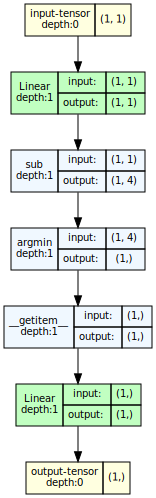

In [7]:
import torch
import torch.nn as nn

from torchview import draw_graph


class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1, 1)
        self.embeddings = nn.Parameter(
            torch.tensor([-10.0, 0.0, 4.0, 3.0]), requires_grad=True
        )
        self.dec = nn.Linear(1, 1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z - self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        d = self.dec(e_j)
        return d


q = Quantize()
x = torch.ones(1).reshape(-1, 1)
out = q(x)
out.backward()
print("Decoder Gradient:", q.dec.weight.grad)
print("Decoder Gradient:", q.embeddings.grad)
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

We can see above, that the gradient didn't make it back to $z$, which is a problem because then gradients arent making it to our encoder in that case. This happens because `argmin` is non-differentiable so PyTorch cannot compute a useful gradient through this operation.

During backpropagation, we have to find the following derivatives:
- Derivative of the Decoder w.r.t codes $\frac{\partial d}{\partial e_{\text{st}}}$
- Derivative of the codes w.r.t z $\frac{\partial e_{\text{st}}}{\partial z}$ (this is the problematic one)
- Derivative of z w.r.t the Encoder $\frac{\partial z}{\partial w_{\text{enc}}}$

This is the complete chain rule for previous model:
$$
\boxed{
\frac{\partial L}{\partial w_{\text{enc}}}
=
\frac{\partial L}{\partial d}
\cdot
\frac{\partial d}{\partial e_{\text{st}}}
\cdot
\frac{\partial e_{\text{st}}}{\partial z}
\cdot
\frac{\partial z}{\partial w_{\text{enc}}}
}
$$


$\frac{\partial L}{\partial w_{\text{enc}}}$ depends on the loss fomula used (MSE, cross-entropy, etc.) so we'll just call it:

$$
\boxed{
\frac{\partial L}{\partial d} = g_{d}
}
$$

For the next step recall that:

$$
d = w_{\text{dec}} \cdot e_{\text{st}} + b_{\text{dec}}
$$

derivative of $b_{\text{dec}}$ is 0 and derivative of $w_{\text{dec}} \cdot e_{\text{st}}$ is $w_{\text{dec}}$ so:

$$
\boxed{
\frac{\partial d}{\partial e_{\text{st}}} = w_{\text{dec}}
}
$$

$\frac{\partial e_{\text{st}}}{\partial z}$ is where everything stops because:

$$
\boxed{
\frac{\partial \text{argmin}_j |z - e_j|}{\partial z} = 0
}
$$

To build an intuition of why this is not derivable imagine to slightly change `z`, the index `j` (the argmin) stays the same most of the time. In other words the function is piecewise constant. Derivative of a constant is 0 almost everywhere, and undefined at the points where the index changes. So there’s no smooth slope for gradient descent to follow.

The proposed solution from the paper was to use a **straight through estimator** [[3]](https://arxiv.org/pdf/1308.3432), where we will copy the gradients from the input of the decoder to the output of the encoder.

To copy gradients we will do it like this:

```
e_j = z + (e_j - z).detach()
```

Why this works?

$$
e_j^{st} = \underbrace{z}_{\text{has grad}}
         + \underbrace{(e_j - z)^{\text{detach}}}_{\text{no grad}}
$$


$$
\frac{\partial e_{\text{st}}}{\partial z} = \frac{\partial z}{\partial z} + \frac{\partial (e_j - z)^{detach}}{\partial z} = 1 + 0 = 1
$$

Put it all together:

$$
\boxed{
\frac{\partial L}{\partial w_{\text{enc}}}
=
\frac{\partial L}{\partial d}
\cdot
\frac{\partial d}{\partial e_{\text{st}}}
\cdot
\frac{\partial e_{\text{st}}}{\partial z}
\cdot
\frac{\partial z}{\partial w_{\text{enc}}}

= g_{d} \cdot w_{\text{dec}} \cdot 1 \cdot w_{\text{enc}}
}
$$

Encoder Gradient: tensor([[0.6091]])


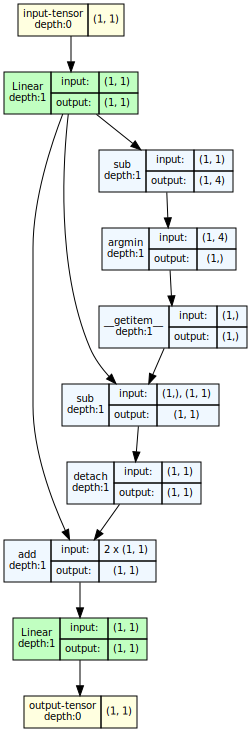

In [3]:
class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1, 1)
        self.embeddings = nn.Parameter(
            torch.tensor([-10.0, 0.0, 4.0, 3.0]), requires_grad=True
        )
        self.dec = nn.Linear(1, 1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z - self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        e_j = z + (e_j - z).detach()
        d = self.dec(e_j)
        return d


q = Quantize()
x = torch.ones(1).reshape(-1, 1)
out = q(x)
out.backward()
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

There is another optimization trick to know. There are two ways we can compute distances; goal is to compute the mean squared distance between our input $x$ and ALL codevectors $e$, so $(x-e)^2$. In the naive method, we will have to do matrix inflation to get all our shapes to line up, but this is costly. The better way is to rewrite $(x-e)^2$ as $x^2-2xe + e^2$ and just do a couple matrix multiplications to get the same output.

In [10]:
import torch
import time


class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super().__init__()

        self.embedding = nn.Embedding(codebook_size, latent_dim)
        self.embedding.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

    def forward(self, x, efficient=True):
        batch_size = x.shape[0]

        ### Bad Implementation That Requires Matrix Expansion ###
        if not efficient:
            # C: Codebook Size, L: Latent Dim

            ### Embedding: [C, L] -> [B, C, L]
            emb = self.embedding.weight.unsqueeze(0).repeat(batch_size, 1, 1)

            ### X: [B, L] -> [B, 1, L]
            x = x.unsqueeze(1)

            ### [B, C]
            distances = torch.sum(((x - emb) ** 2), dim=-1)

        ### Alternative more Efficient Implementation ###
        else:
            ### Distance btwn every Latent and Code: (L-C)**2 = (L**2 - 2LC + C**2 ) ###

            ### L2: [B, L] -> [B, 1]
            L2 = torch.sum(x**2, dim=1, keepdim=True)

            ### C2: [C, L] -> [C]
            C2 = torch.sum(self.embedding.weight**2, dim=1).unsqueeze(0)

            ### CL: [B,L]@[L,C] -> [B, C]
            CL = x @ self.embedding.weight.t()

            ### [B, 1] - 2 * [B, C] + [C] -> [B, C]
            distances = L2 - 2 * CL + C2

        ### Grab Closest Indexes, create matrix of corresponding vectors ###
        ### Closest: [B, 1]
        closest = torch.argmin(distances, dim=-1)

        ### Create Empty Quantized Latents Embedding ###
        # latents_idx: [B, C]
        quantized_latents_idx = torch.zeros(
            batch_size, self.codebook_size, device=x.device
        )

        ### Place a 1 at the Indexes for each sample for the codebook we want ###
        batch_idx = torch.arange(batch_size)
        quantized_latents_idx[batch_idx, closest] = 1

        ### Matrix Multiplication to Grab Indexed Latents from Embeddings ###

        # quantized_latents: [B, C] @ [C, L] -> [B, L]
        quantized_latents = quantized_latents_idx @ self.embedding.weight

        return quantized_latents


def benchmark_vq(
    codebook_size=1024, latent_dim=64, batch_size=256, iters=50, device=None
):
    """Benchmark speed + peak memory of efficient vs inefficient quantization in a single function."""

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Benchmark (device={device}) ---")
    print(f"Batch={batch_size}, Codebook={codebook_size}, Latent={latent_dim}")

    vq = VectorQuantizer(codebook_size=codebook_size, latent_dim=latent_dim).to(device)
    x = torch.randn(batch_size, latent_dim, device=device)

    # Warmup
    with torch.no_grad():
        vq(x, efficient=False)
        vq(x, efficient=True)

    def measure(fn):
        if device == "cuda":
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        start = time.time()
        with torch.no_grad():
            for _ in range(iters):
                fn()
        end = time.time()

        t = (end - start) / iters
        mem = torch.cuda.max_memory_allocated() if device == "cuda" else None
        return t, mem

    # Inefficient
    t_slow, mem_slow = measure(lambda: vq(x, efficient=False))

    # Efficient
    t_fast, mem_fast = measure(lambda: vq(x, efficient=True))

    # Print results
    def fmt(m):
        return f"{m / (1024**2):.2f} MB" if m is not None else "N/A (CPU)"

    print(f"\nInefficient (repeat expand):")
    print(f"  time   : {t_slow * 1000:.3f} ms/iter")
    print(f"  memory : {fmt(mem_slow)}")

    print(f"\nEfficient (no expand):")
    print(f"  time   : {t_fast * 1000:.3f} ms/iter")
    print(f"  memory : {fmt(mem_fast)}")

    if mem_slow and mem_fast:
        print(f"\nMemory ratio (ineff/eff): {mem_slow / mem_fast:.2f}x")
    print(f"Speedup (ineff/eff): {t_slow / t_fast:.2f}x")


benchmark_vq(codebook_size=1024, latent_dim=64, batch_size=64)
benchmark_vq(codebook_size=1024, latent_dim=64, batch_size=512)
benchmark_vq(codebook_size=4096, latent_dim=64, batch_size=512)


--- Benchmark (device=cuda) ---
Batch=64, Codebook=1024, Latent=64

Inefficient (repeat expand):
  time   : 0.422 ms/iter
  memory : 56.39 MB

Efficient (no expand):
  time   : 0.290 ms/iter
  memory : 9.17 MB

Memory ratio (ineff/eff): 6.15x
Speedup (ineff/eff): 1.45x

--- Benchmark (device=cuda) ---
Batch=512, Codebook=1024, Latent=64

Inefficient (repeat expand):
  time   : 4.072 ms/iter
  memory : 392.50 MB

Efficient (no expand):
  time   : 0.353 ms/iter
  memory : 14.64 MB

Memory ratio (ineff/eff): 26.81x
Speedup (ineff/eff): 11.55x

--- Benchmark (device=cuda) ---
Batch=512, Codebook=4096, Latent=64

Inefficient (repeat expand):
  time   : 15.308 ms/iter
  memory : 1545.25 MB

Efficient (no expand):
  time   : 0.478 ms/iter
  memory : 33.40 MB

Memory ratio (ineff/eff): 46.26x
Speedup (ineff/eff): 32.06x


![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Convolutional_neural_network%2C_convolution_worked_example.png)

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=256):
        super().__init__()

        # 2x strided conv layers: 4x4, stride 2, 256 channels
        self.conv1 = nn.Conv2d(
            in_channels, hidden_dim, kernel_size=4, stride=2, padding=1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1
        )

        # Residual blocks: ReLU → 3x3 conv → ReLU → 1x1 conv
        self.res1_conv3 = nn.Conv2d(
            hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1
        )
        self.res1_conv1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1)
        self.res2_conv3 = nn.Conv2d(
            hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1
        )
        self.res2_conv1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1)

    def forward(self, x):
        # conv block
        x = self.conv1(x)  # [B, C, H/2, W/2]
        x = self.conv2(x)  # [B, C, H/2, W/2]

        # residual block 1
        out = F.relu(x)
        out = self.res1_conv3(out)  # [B, C, H, W]
        out = F.relu(out)
        out = self.res1_conv1(out)  # [B, C, H, W]
        x = x + out

        # residual block 2
        out = F.relu(x)
        out = self.res2_conv3(out)  # [B, C, H, W]
        out = F.relu(out)
        out = self.res2_conv1(out)  # [B, C, H, W]
        x = x + out

        return x


class Decoder(nn.Module):
    def __init__(self, out_channels=3, hidden_dim=256):
        super().__init__()

        # Residual blocks: mirror of the encoder’s ResNet-style blocks
        self.res1_conv3 = nn.Conv2d(
            hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1
        )
        self.res1_conv1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1)

        self.res2_conv3 = nn.Conv2d(
            hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1
        )
        self.res2_conv1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1)

        # 2x upsampling with transposed convs: 4x4, stride 2
        self.deconv1 = nn.ConvTranspose2d(
            hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            hidden_dim, out_channels, kernel_size=4, stride=2, padding=1
        )

    def forward(self, x):
        # residual block 1
        out = F.relu(x)
        out = self.res1_conv3(out)
        out = F.relu(out)
        out = self.res1_conv1(out)
        x = x + out

        # residual block 2
        out = F.relu(x)
        out = self.res2_conv3(out)
        out = F.relu(out)
        out = self.res2_conv1(out)
        x = x + out

        # upsampling back to image resolution
        x = F.relu(x)
        x = self.deconv1(x)
        x = self.deconv2(x)

        return x

In [47]:
import torch
import torch.nn as nn
from vq import VectorQuantizer

B = 1
C = 1
H, W = 12, 12
D = 64

# A simple 5x5 image with 1 channel
x = torch.arange(144, dtype=torch.float32).reshape(1, 1, H, W)  # [B, C, H, W]
vq = VectorQuantizer(100, D)
enc = Encoder(1, D)
dec = Decoder(1, D)
print("Input shape:", x.shape)

z_e = enc(x)
print(z_e.shape)
_, _, H_e, W_e = z_e.shape
z_e = z_e.permute(0, 2, 3, 1)  # [B, H, W, D]
z_e = z_e.view(-1, D)
print(z_e.shape)
z_q, ids = vq(z_e)
print(z_q.shape)
z_q = z_q.view(B, H_e, W_e, D)
z_q = z_q.permute(0, 3, 1, 2)
print(z_q.shape)
y = dec(z_q)
print(y.shape)

Input shape: torch.Size([1, 1, 12, 12])
torch.Size([1, 64, 3, 3])
torch.Size([9, 64])
torch.Size([9, 64])
torch.Size([1, 64, 3, 3])
torch.Size([1, 1, 12, 12])


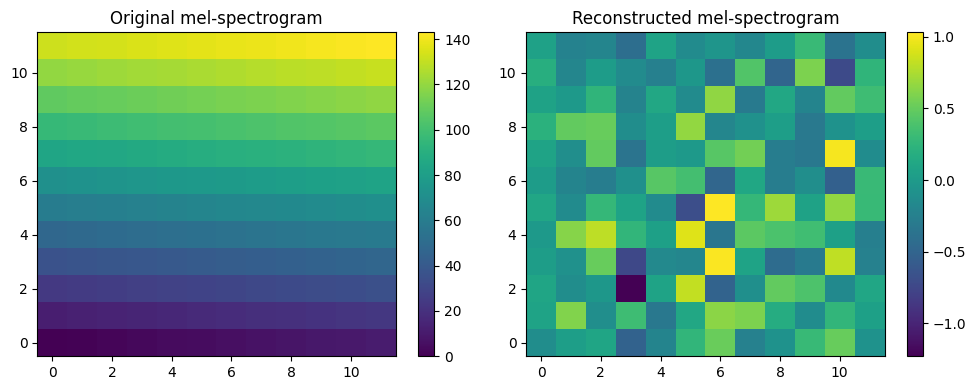

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# x: original input  [1, 1, H, W]
# y: reconstructed   [1, 1, H, W]

x_img = x.squeeze().detach().cpu().numpy()  # [H, W]
y_img = y.squeeze().detach().cpu().numpy()  # [H, W]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original mel-spectrogram")
plt.imshow(x_img, aspect="auto", origin="lower")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Reconstructed mel-spectrogram")
plt.imshow(y_img, aspect="auto", origin="lower")
plt.colorbar()

plt.tight_layout()
plt.show()

In [39]:
ids

tensor([13, 56, 68, 16, 56, 92, 16, 16, 16])

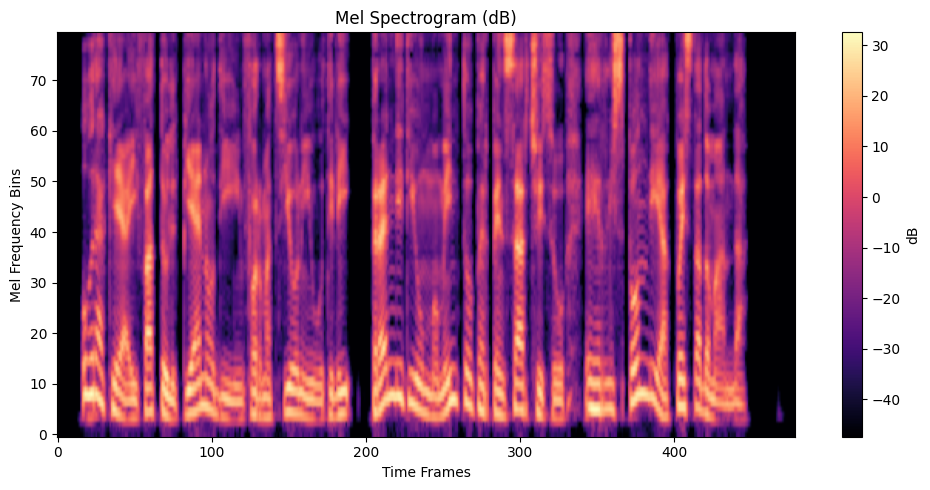

In [7]:
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

waveform, sample_rate = torchaudio.load("../../data/audio/M01UD01p10.wav")

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate, n_fft=1024, hop_length=256, n_mels=80
)

mel = mel_transform(waveform)

mel_db = torchaudio.functional.amplitude_to_DB(
    mel, multiplier=10.0, amin=1e-10, db_multiplier=0.0, top_db=80
)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(mel_db[0].numpy(), aspect="auto", origin="lower", cmap="magma")
plt.title("Mel Spectrogram (dB)")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()

In [8]:
plt.figure(figsize=(10, 5))
plt.imshow(mel_db[0].numpy(), aspect="auto", origin="lower", cmap="magma")
plt.axis("off")  # remove axes
plt.tight_layout(pad=0)
plt.savefig("mel.png", dpi=150, bbox_inches="tight", pad_inches=0)
plt.close()